In [166]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

In [332]:
def BoB_plot(input_data,title,output):
########## Data ########
    input_data=input_data.rename({input_data.dims[0]:'time'})
    BoB_altimeter_unfiltered_summer={}
    for i in range(1994,2019):
        summer_unfiltered=input_data.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
        BoB_altimeter_unfiltered_summer[i]=[]
        BoB_altimeter_unfiltered_summer[i].append(summer_unfiltered)
    lon=input_data[input_data.dims[2]].data
    lat=input_data[input_data.dims[1]].data
########## Info ######
    Summer_enso_info={}
    Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                        1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                        2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                        2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                        2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                        2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

    Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
    Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]

##########   Ploting ###########
    fig, axs = plt.subplots(nrows=5,ncols=5,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))

    axs=axs.flatten()
    y_label=set([0,5,10,15,20])
    x_label=set([20,21,22,23,24])
    levels=[-20,-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15,20]
    for i,year in enumerate(BoB_altimeter_unfiltered_summer):
            data=BoB_altimeter_unfiltered_summer[year]
            cs=axs[i].contourf(lon,lat,data[0],
                              levels=levels,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 15, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
            if year in Elnino_years:
                axs[i].text(87,23, Summer_enso_info[year],color='red', fontsize = 10,weight='bold')
            if year in Lanina_years:
                axs[i].text(87,23, Summer_enso_info[year],color='blue', fontsize = 10,weight='bold')

    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold',fontname='Times New Roman')
    plt.savefig(output,dpi=120)
    
    return 

In [281]:
BoB_altimeter.dims[0]

'time'

# Altimeter Unfiltered

In [325]:
BoB_altimeter=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021.nc',autoclose=True).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

In [329]:
BoB_altimeter=BoB_altimeter.rename({BoB_altimeter.dims[0]:'time'})
BoB_altimeter

<xarray.DataArray 'sla' (time: 9672, latitude: 84, longitude: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
  * longitude  (longitude) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88

('time', 'latitude', 'longitude')


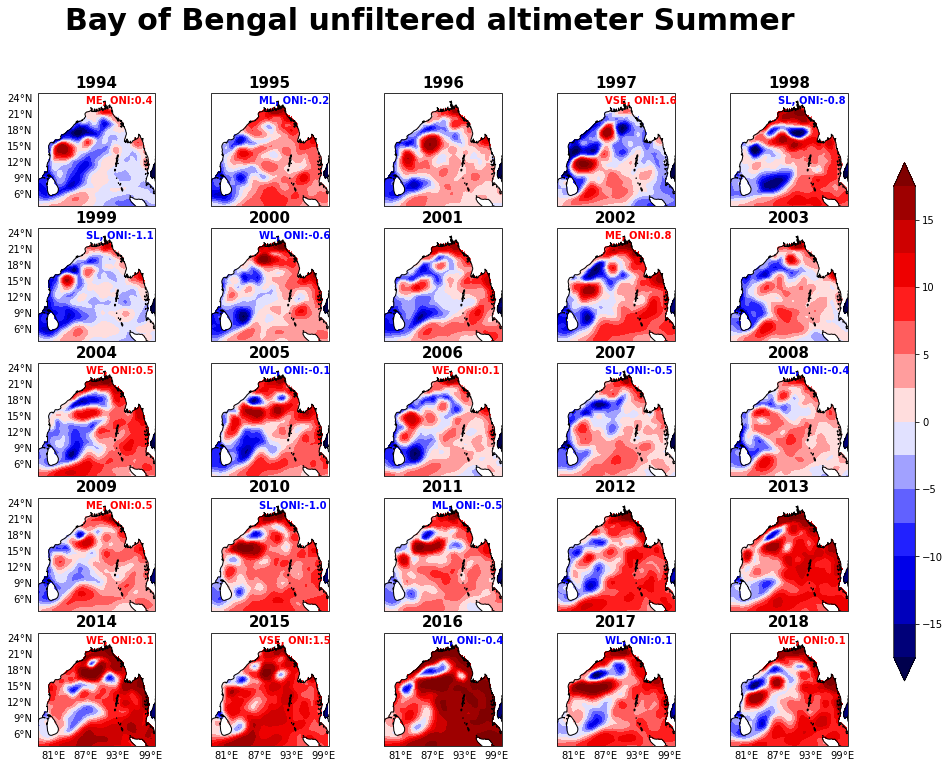

In [313]:
i=BoB_altimeter
print(i.dims)
BoB_plot(i,time,"Bay of Bengal unfiltered altimeter Summer",
         'BoB_unfiltered_altimeter.jpg')

# LCS Unfilltered

In [11]:
BoB_lcs=xr.open_mfdataset('lcs_sla1.nc',autoclose=True).sel(lat=slice(4,25),lon=slice(78,100)).sla

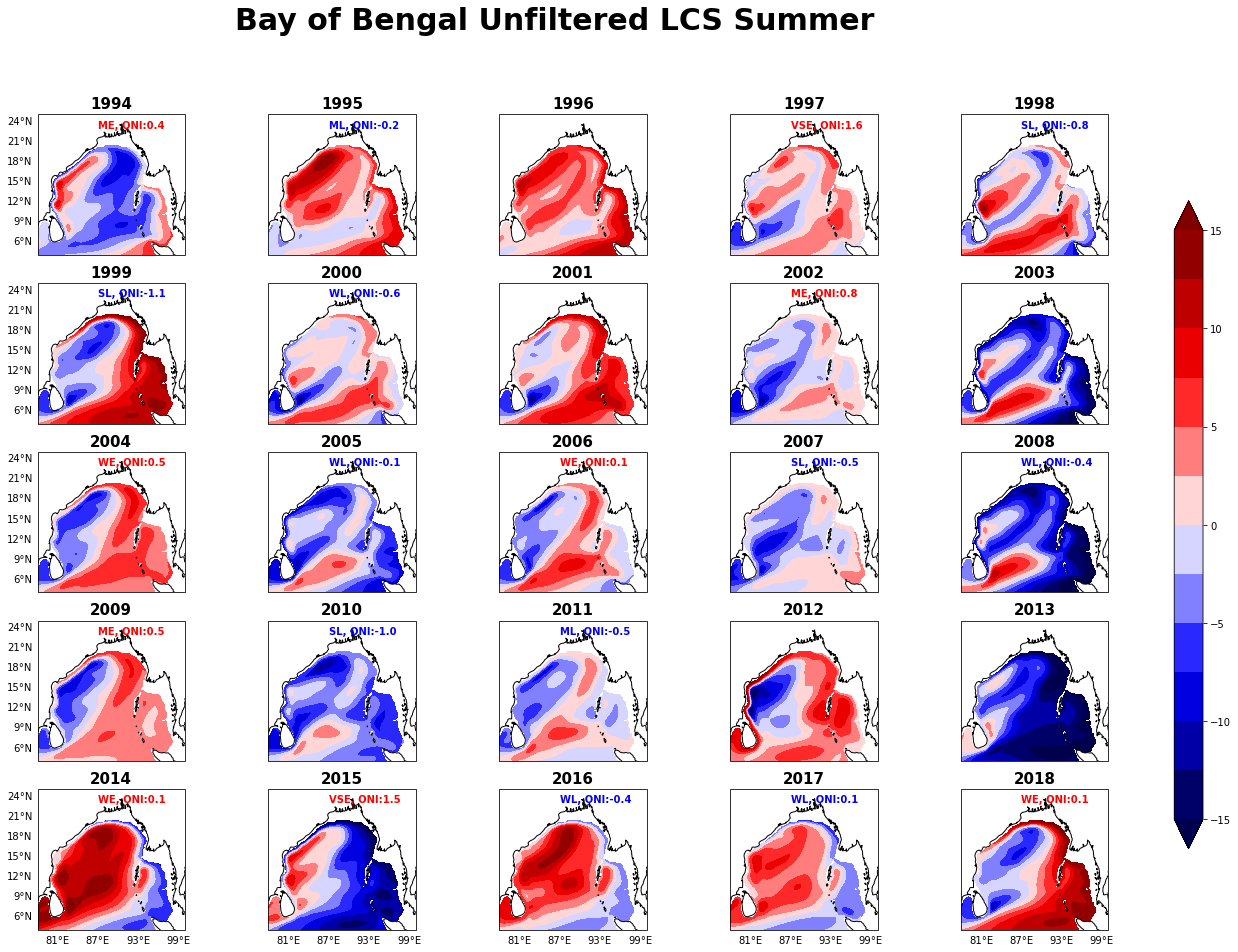

In [44]:
########## Data ########
BoB_lcs_unfiltered_summer={}
for i in range(1994,2019):
    summer_unfiltered=BoB_lcs.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
    BoB_lcs_unfiltered_summer[i]=[]
    BoB_lcs_unfiltered_summer[i].append(summer_unfiltered)
    
########## Info ######
Summer_enso_info={}
Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                    1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                    2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                    2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                    2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                    2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]

##########   Ploting ###########
fig, axs = plt.subplots(nrows=5,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

axs=axs.flatten()
y_label=set([0,5,10,15,20])
x_label=set([20,21,22,23,24])
levels=[-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15]
for i,year in enumerate(BoB_lcs_unfiltered_summer):
        data=BoB_lcs_unfiltered_summer[year]
        cs=axs[i].contourf(BoB_lcs.lon.data,BoB_lcs.lat.data,data[0],
                          levels=levels,transform = ccrs.PlateCarree(),
                          cmap='seismic',extend='both')
        axs[i].set_extent([78,100,4,25])
        axs[i].set_title(year,fontsize = 15, weight='bold')
        axs[i].coastlines()
        if i in y_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.bottom_labels = False
            gl.right_labels = False
            #gl.xlines=False
        if i in x_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.left_labels = False
            gl.right_labels = False
        if year in Elnino_years:
            axs[i].text(87,23, Summer_enso_info[year],color='red', fontsize = 10,weight='bold')
        if year in Lanina_years:
            axs[i].text(87,23, Summer_enso_info[year],color='blue', fontsize = 10,weight='bold')

cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
cba=fig.colorbar(cs,cax=cb_ax)
plt.suptitle("Bay of Bengal Unfiltered LCS Summer",fontsize = 30,weight='bold',fontname='Times New Roman')
plt.savefig('BoB_unfiltered_LCS.jpg',dpi=120)

## Filtering code

In [30]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, order=2, cutoff_freq=1.0/10.0, axis=0):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    B, A = signal.butter(order, cutoff_freq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

# Altimeter Filtered

## ferret filtering

In [337]:
BoB_ferret_filtered=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021_low_new.nc',autoclose=True).sel(LATITUDE=slice(4,25),LONGITUDE=slice(78,100)).SLA_LOW

In [338]:
BoB_ferret_filtered

<xarray.DataArray 'SLA_LOW' (TIME: 9672, LATITUDE: 84, LONGITUDE: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * LONGITUDE  (LONGITUDE) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * LATITUDE   (LATITUDE) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
Attributes:
    long_name:  LSL_LOWPASS(SLA,400,400)
    history:    From IO_sla_new

('TIME', 'LATITUDE', 'LONGITUDE')


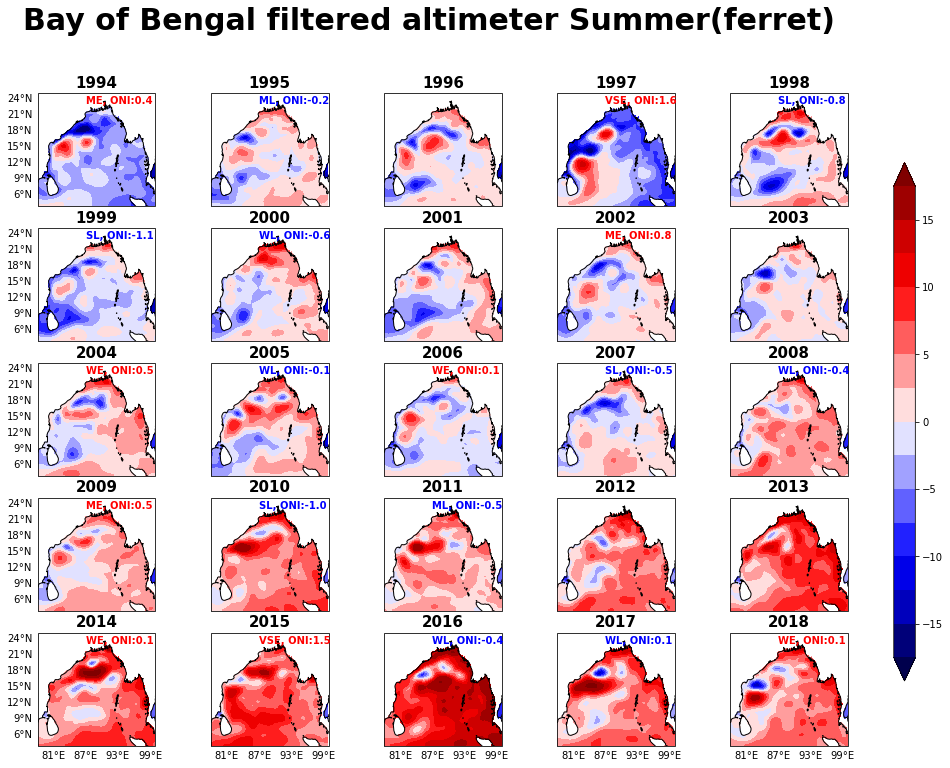

In [340]:
i=BoB_ferret_filtered
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(ferret)",
         'BoB_filtered_altimeter_ferret.jpg')

## Altimeter filtering in python

In [171]:
BoB_altimeter_low = butterworth_lowpass_filter(BoB_altimeter, cutoff_freq=1 / 400.0)


In [172]:
BoB_altimeter_low=xr.DataArray(BoB_altimeter_low,coords=
                                   {"time": BoB_altimeter.time, "latitude": BoB_altimeter.latitude,
                          "longitude": BoB_altimeter.longitude},
                  dims=["time", "latitude","longitude"])
BoB_altimeter_low['sla_low']=BoB_altimeter_low


('time', 'latitude', 'longitude')


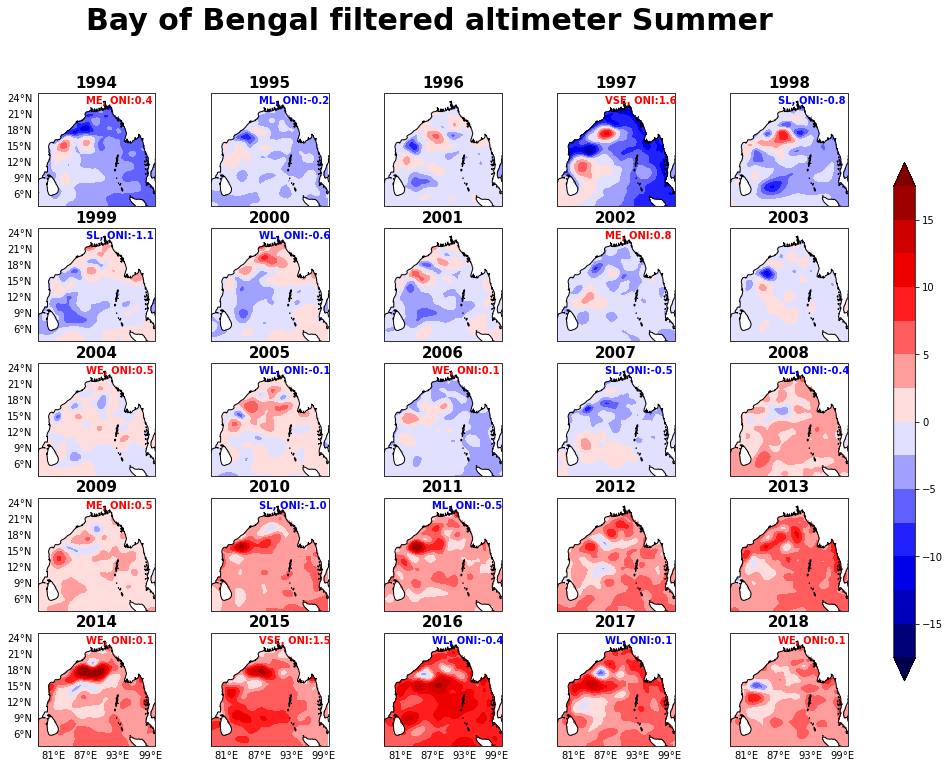

In [341]:
i=BoB_altimeter_low
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer",
         'BoB_filtered_altimeter.jpg')

# LCS Filtered

In [41]:
BoB_lcs_low = butterworth_lowpass_filter(BoB_lcs, cutoff_freq=1 / 400.0)


In [174]:
BoB_lcs_low=xr.DataArray(BoB_lcs_low,coords=
                                   {"time": BoB_lcs.time, "latitude": BoB_lcs.lat,
                          "longitude": BoB_lcs.lon},
                  dims=["time", "lat","lon"])
BoB_lcs_low['sla_low']=BoB_lcs_low


('time', 'lat', 'lon')


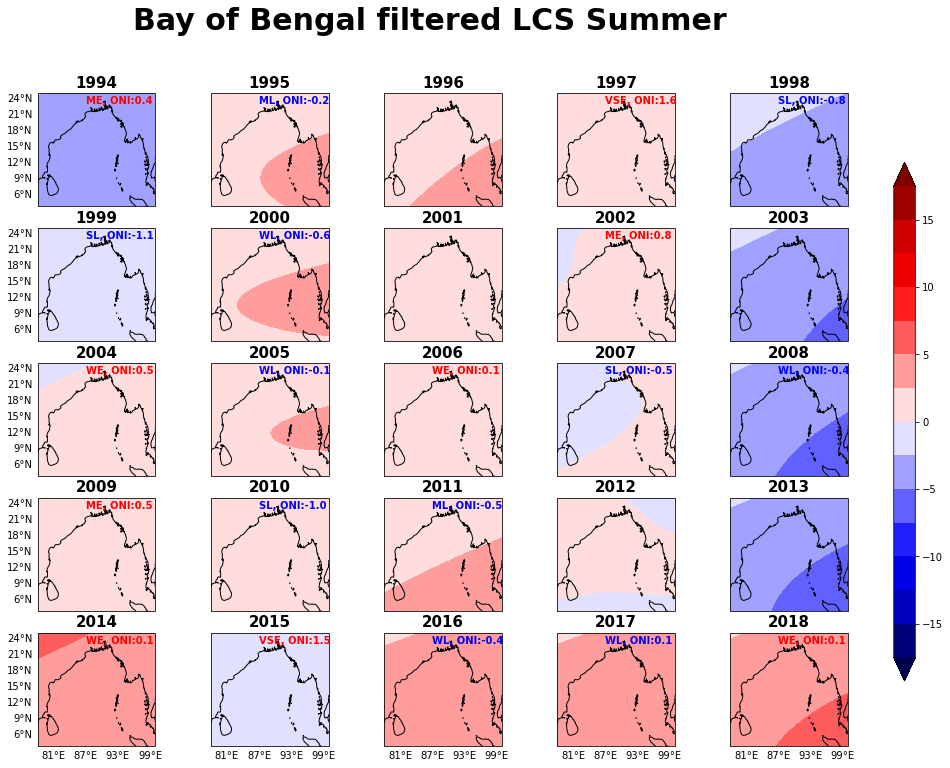

In [342]:
i=BoB_lcs_low
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered LCS Summer",
         'BoB_filtered_lcs.jpg')

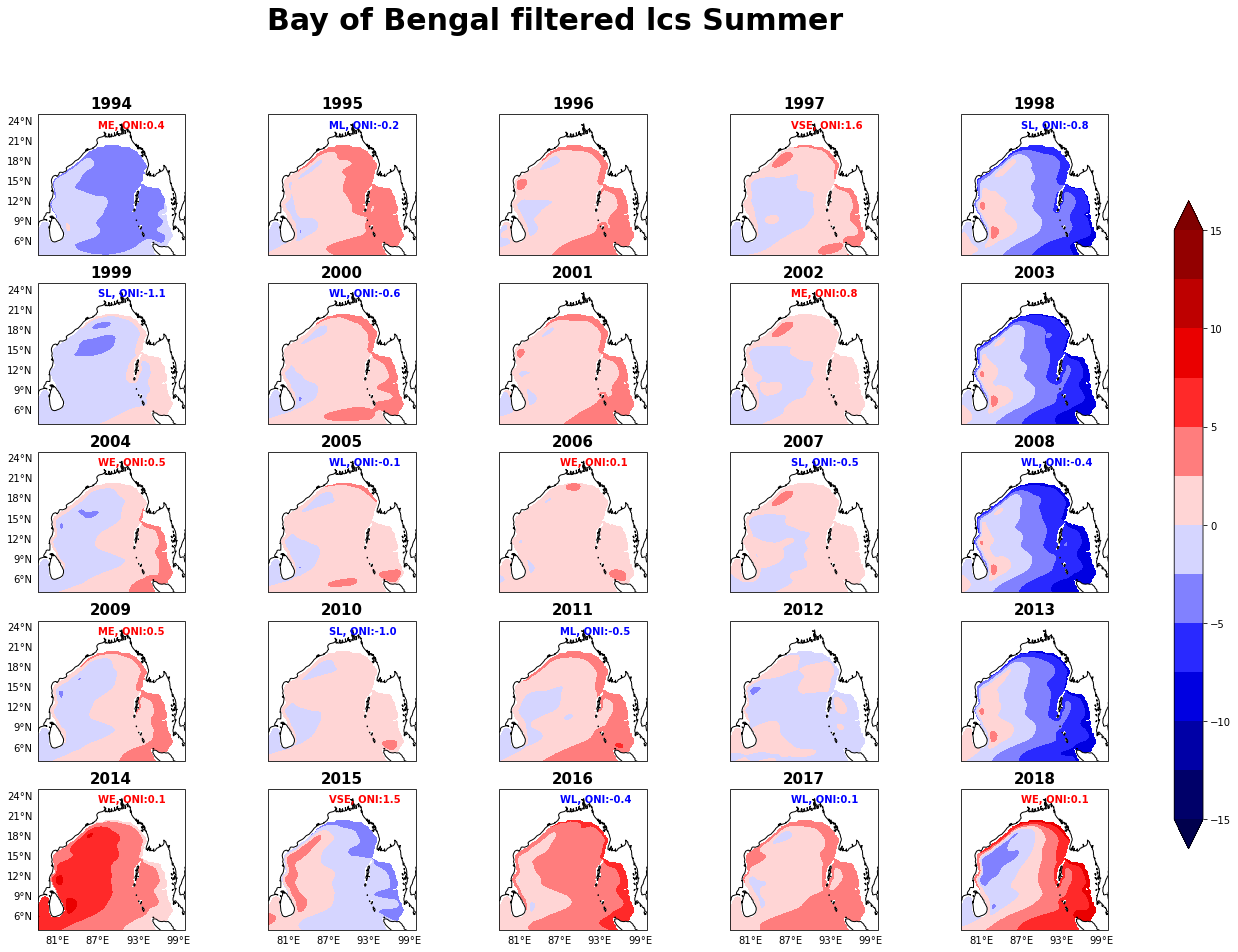

In [177]:
########## Data ########
BoB_lcs_filtered_summer={}
for i in range(1994,2019):
    summer_filtered=BoB_lcs_low.sel(time=slice(repr(i)+'-06-01',repr(i)+'-08-31')).mean(dim='time')
    BoB_lcs_filtered_summer[i]=[]
    BoB_lcs_filtered_summer[i].append(summer_filtered)
    
########## Info ######
Summer_enso_info={}
Summer_enso_info=dict({1993:None,1994:'ME, ONI:0.4',1995:'ML, ONI:-0.2',1996: None,1997:'VSE, ONI:1.6',
                    1998:'SL, ONI:-0.8',1999:'SL, ONI:-1.1',2000:'WL, ONI:-0.6',2001:None,2002:'ME, ONI:0.8',
                    2003:None,2004:'WE, ONI:0.5',2005:'WL, ONI:-0.1',2006:'WE, ONI:0.1',2007:'SL, ONI:-0.5',
                    2008:'WL, ONI:-0.4',2009:'ME, ONI:0.5',2010:'SL, ONI:-1.0',2011:'ML, ONI:-0.5',2012:None,
                    2013:None,2014:'WE, ONI:0.1',2015:'VSE, ONI:1.5',2016:'WL, ONI:-0.4',2017:'WL, ONI:0.1',
                    2018:'WE, ONI:0.1',2019:None,2020:'ML, ONI:-0.4',2021:'ML, ONI:-0.4'})

Elnino_years=[1994,1997,2002,2004,2006,2009,2014,2015,2018]
Lanina_years=[1995,1998,1999,2000,2005,2007,2008,2010,2011,2016,2017,2020,2021]

##########   Ploting ###########
fig, axs = plt.subplots(nrows=5,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,15))

axs=axs.flatten()
y_label=set([0,5,10,15,20])
x_label=set([20,21,22,23,24])
levels=[-15,-12.5,-10,-7.5,-5,-2.5,0,2.5,5,7.5,10,12.5,15]
for i,year in enumerate(BoB_lcs_filtered_summer):
        data=BoB_lcs_filtered_summer[year]
        cs=axs[i].contourf(BoB_lcs_low.longitude.data,BoB_lcs_low.latitude.data,data[0],
                          levels=levels,transform = ccrs.PlateCarree(),
                          cmap='seismic',extend='both')
        axs[i].set_extent([78,100,4,25])
        axs[i].set_title(year,fontsize = 15, weight='bold')
        axs[i].coastlines()
        if i in y_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.bottom_labels = False
            gl.right_labels = False
            #gl.xlines=False
        if i in x_label:
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
            gl.top_labels = False
            gl.left_labels = False
            gl.right_labels = False
        if year in Elnino_years:
            axs[i].text(87,23, Summer_enso_info[year],color='red', fontsize = 10,weight='bold')
        if year in Lanina_years:
            axs[i].text(87,23, Summer_enso_info[year],color='blue', fontsize = 10,weight='bold')

cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
cba=fig.colorbar(cs,cax=cb_ax)
plt.suptitle("Bay of Bengal filtered lcs Summer",fontsize = 30,weight='bold',fontname='Times New Roman')
plt.savefig('BoB_filtered_lcs.jpg',dpi=120)

In [ ]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, order=2, cutoff_freq=1.0/10.0, axis=0):
    """Filter input data.
    
    For unfiltered data, use `cutoff_freq=1`.
    
    Currently, this returns a numpy array.
    """
    B, A = signal.butter(order, cutoff_freq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

('time', 'lat', 'lon')


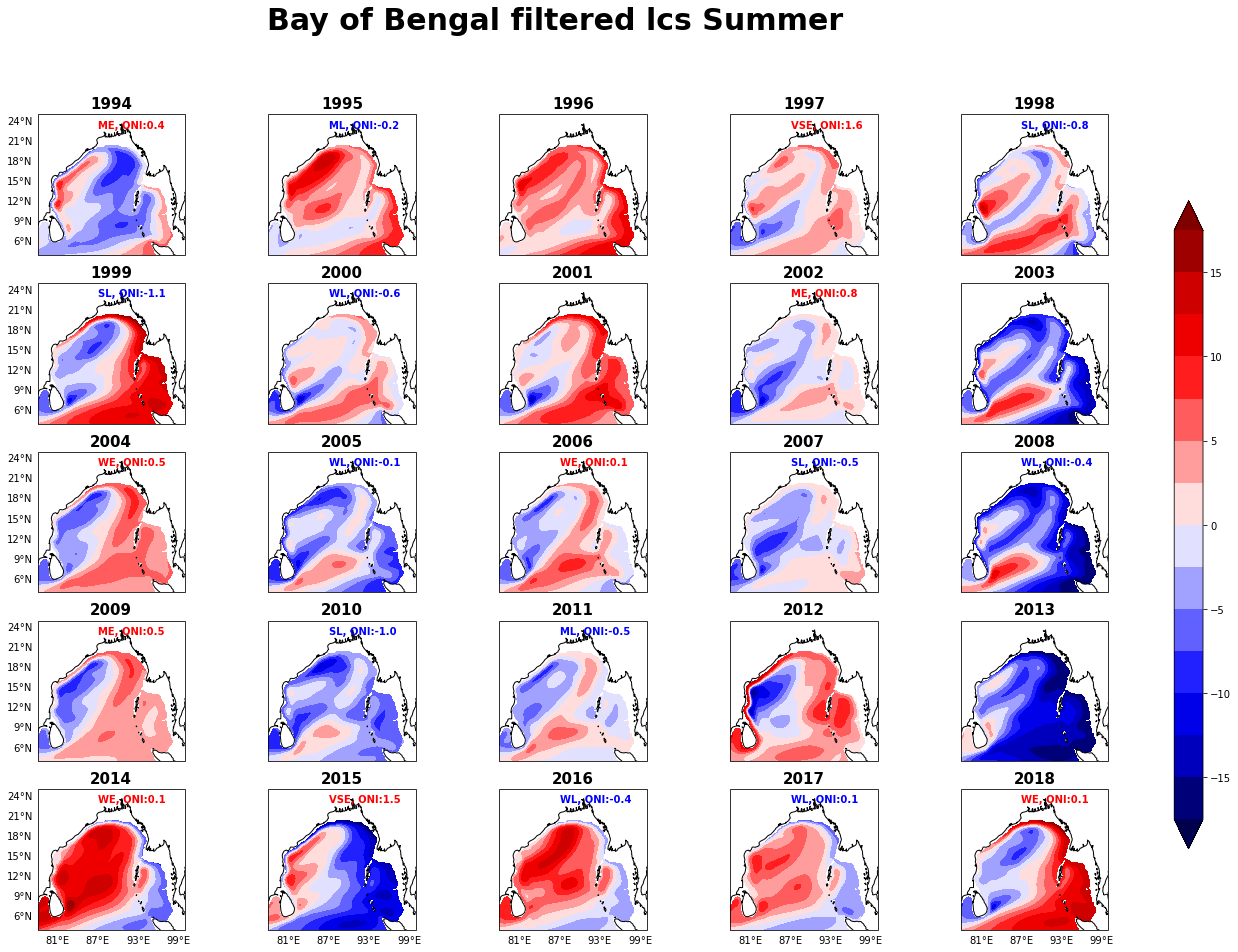

In [259]:
i=BoB_lcs
print(i.dims)
BoB_plot(i,i.lon.data,i.lat.data,
         time,"Bay of Bengal filtered lcs Summer",
         'BoB_filtered_lcs.jpg')

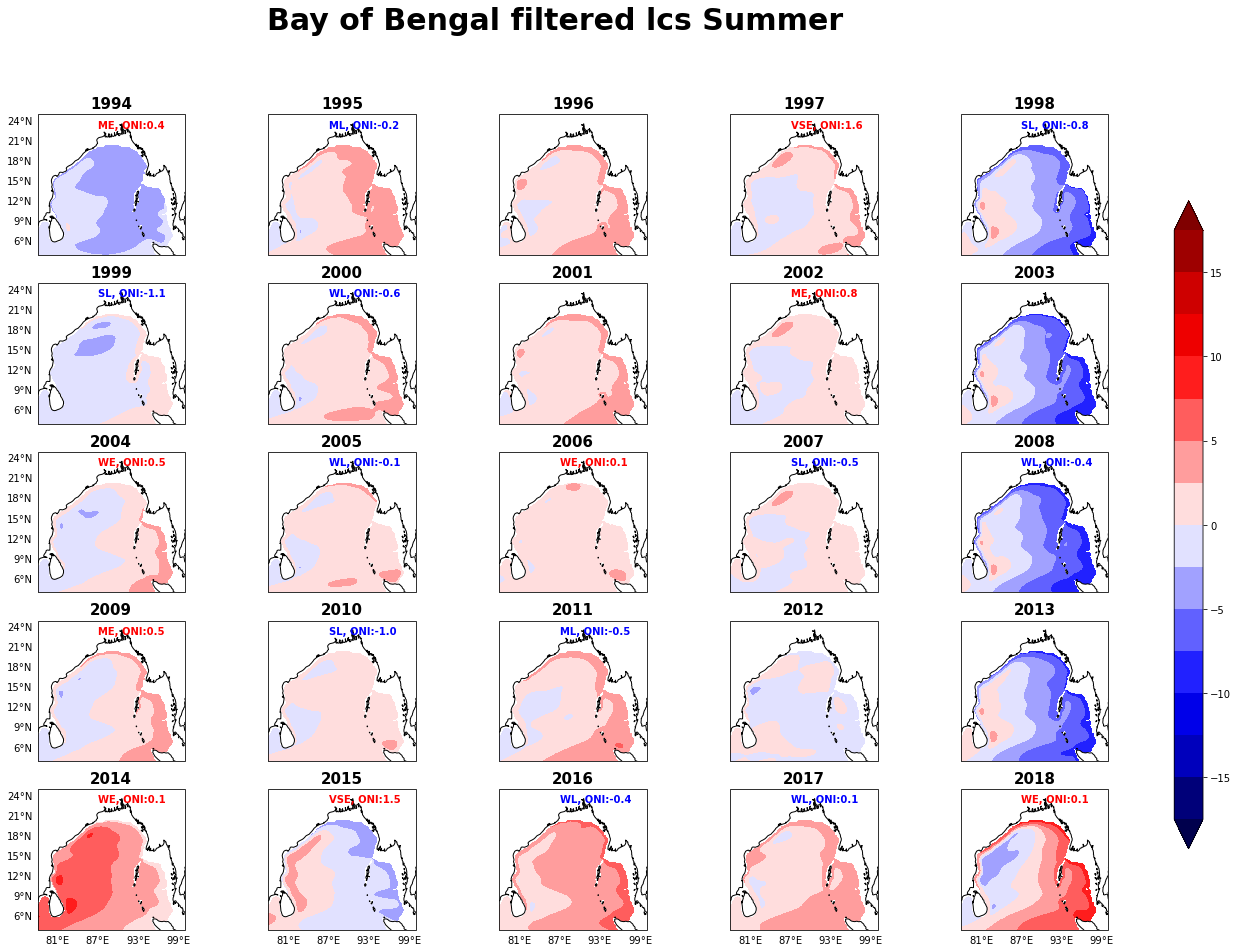

In [257]:
BoB_plot(BoB_lcs_low,BoB_lcs_low.longitude.data,
         BoB_lcs_low.latitude.data,time,
         )

In [288]:
BoB_lcs_low['longitude'].data

array([ 78.      ,  78.100006,  78.2     ,  78.3     ,  78.4     ,
        78.5     ,  78.600006,  78.7     ,  78.8     ,  78.9     ,
        79.      ,  79.100006,  79.2     ,  79.3     ,  79.4     ,
        79.5     ,  79.600006,  79.7     ,  79.8     ,  79.9     ,
        80.      ,  80.100006,  80.2     ,  80.3     ,  80.4     ,
        80.5     ,  80.600006,  80.7     ,  80.8     ,  80.9     ,
        81.      ,  81.100006,  81.2     ,  81.3     ,  81.4     ,
        81.5     ,  81.600006,  81.7     ,  81.8     ,  81.9     ,
        82.      ,  82.100006,  82.2     ,  82.3     ,  82.4     ,
        82.5     ,  82.600006,  82.7     ,  82.8     ,  82.9     ,
        83.      ,  83.100006,  83.2     ,  83.3     ,  83.4     ,
        83.5     ,  83.600006,  83.7     ,  83.8     ,  83.9     ,
        84.      ,  84.100006,  84.2     ,  84.3     ,  84.4     ,
        84.5     ,  84.600006,  84.7     ,  84.8     ,  84.9     ,
        85.      ,  85.100006,  85.2     ,  85.3     ,  85.4  